In [ ]:
import sys
import numpy as npy
import pandas as pds
from sklearn.metrics import *
import matplotlib.pyplot as plot
from sklearn.preprocessing import *

In [ ]:
def squashingSigmoidFunc(xParameter):
    sigmoidResult = 1 / (1 + npy.exp(-xParameter))
    return sigmoidResult

def squashingSigmoidDiff(yParameter):
    sigmoidDiffResult = yParameter * (1 - yParameter)
    return sigmoidDiffResult

def tangentFunc(x):
    tangentVal = npy.tanh(x)
    return tangentVal

def tangentFuncDiff(y):
    tangentDiffVal = 1 - y * y
    return tangentDiffVal

def getArray(parameter):
    arrayRes = npy.array(parameter)
    return arrayRes

def getSequences(df, winSize):
    X = []
    Y = []
    len = df.shape[0]
    itr =1;
    while(itr <= len):
        if itr + winSize + 1 > df.index[-1]:
            break
        locX = df.iloc[itr:itr+winSize]
        locY = df.iloc[itr+winSize+1]
        X.append(locX)
        Y.append(locY)
        arrayX = getArray(X)
        arrayY = getArray(Y)
        itr +=1
    return arrayX, arrayY

def split(X, Y, r):
    len = X.shape[0]
    splitData = int(len*r)
    X1 = X[:splitData]
    X2 = X[splitData:]
    Y1 = Y[:splitData]
    Y2 = Y[splitData:]
    return X1, X2, Y1, Y2

def getRandomValue(frame, sdWeight, var,d):
    frameX = frame[0]
    frameY = frame[1]
    if(d == 30):
      val = npy.random.rand(frameX, frameY) * sdWeight + var
    return val

def getNumpyZerosLike(frame):
    arr = npy.zeros_like(frame)
    return arr

def getNumpyZeros(layr, val):
    arr = npy.zeros((layr, val))
    return arr

def stackArray(vecA,vecB):
    stack = npy.vstack((vecA, vecB))
    return stack

def getIpData(df):
    IpData = df.iloc[:, [1]]
    return IpData

def readCSV(url):
    file = pds.read_csv(url)
    return file

sclr = MinMaxScaler()
def fitScalerData(IpData):
    sclr.fit(IpData);
def transformData(IpData):
    IpData = sclr.transform(IpData)
    return IpData
def downloadReadings(Readings):
    Readings.to_csv('Readings.csv', index=False)
    return True

In [ ]:
class SetParams:
    def __init__(self, title, frame, sdWeight, var=0, d=30):
        self.title = title
        self.value = getRandomValue(frame,sdWeight,var,d)
        self.diff = getNumpyZerosLike(self.value)
        self.m = getNumpyZerosLike(self.value)

class LongShortTermMemory:
    def __init__(self, LRate, maxItrs, stepTime, frame, hiddenLyrs=10, flag=True):
        self.LRate = LRate
        self.maxItrs = maxItrs
        self.stepTime = stepTime
        self.frame = frame
        self.hiddenLyrs = hiddenLyrs
        if(flag):
          self.initializeForgotGateParameters()
          self.initializeInputGateParameters()
          self.initializeOutputGateParameters()
          self.initializeFinalOutputParameters()

    def initializeForgotGateParameters(self):
        # Parameters for Forget gate
        self.WeightForget = SetParams('Weight_Forget', frame=(self.hiddenLyrs, self.hiddenLyrs+self.frame[0]), sdWeight=0.1, var=0.5)
        self.BiasedForget = SetParams('Biased_Forget', frame=(self.hiddenLyrs, 1), sdWeight=0.1)
    def initializeInputGateParameters(self):
        # Parameters for Input gate
        self.WeightInput = SetParams('Weight_Input', frame=(self.hiddenLyrs, self.hiddenLyrs+self.frame[0]), sdWeight=0.1, var=0.5)
        self.BiasedInput = SetParams('Biased_Input', frame=(self.hiddenLyrs, 1), sdWeight=0.1)
    def initializeOutputGateParameters(self):
        # Parameters for Ouput gate
        # weight central, final
        self.WeightCentral = SetParams('Weight_Central', frame=(self.hiddenLyrs, self.hiddenLyrs+self.frame[0]), sdWeight=0.1, var=0.5)
        self.BiasedCentral = SetParams('Biased_Central', frame=(self.hiddenLyrs, 1), sdWeight=0.1)
        self.WeightOutput = SetParams('Weight_Output', frame=(self.hiddenLyrs, self.hiddenLyrs+self.frame[0]), sdWeight=0.1, var=0.5)
        self.BiasedOutput = SetParams('Biased_Output', frame=(self.hiddenLyrs, 1), sdWeight=0.1)
    def initializeFinalOutputParameters(self):
        # Parameters for Final Output
        self.WeightFinal = SetParams('Weight_Final', frame=(self.frame[1], self.hiddenLyrs), sdWeight=0.1, var=0.5)
        self.BiasedFinal = SetParams('Biased_Final', frame=(self.frame[1], 1), sdWeight=0.1)
        flag = False

    def initiateFwd(self, vecX):
        self.vecX = vecX
        hiddenStateVector = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime)]
        cellStateVector = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime)]
        forgetGateVector = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime)]
        inputUpdateGateVector = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime)]
        cellInputVector = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime)]
        outputGateVector = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime)]

        it = 0
        while it < (self.stepTime):
            zVector = stackArray(hiddenStateVector[it-1], vecX[it])
            forgetGateVector[it] = squashingSigmoidFunc((self.WeightForget.value @ zVector) + self.BiasedForget.value)
            inputUpdateGateVector[it] = squashingSigmoidFunc((self.WeightInput.value @ zVector) + self.BiasedInput.value)
            cellInputVector[it] = tangentFunc((self.WeightCentral.value @ zVector) + self.BiasedCentral.value)
            cellStateVector[it] = (forgetGateVector[it] * cellStateVector[it-1]) + (inputUpdateGateVector[it] * cellInputVector[it])
            outputGateVector[it] = squashingSigmoidFunc((self.WeightOutput.value @ zVector) + self.BiasedOutput.value)
            hiddenStateVector[it] = outputGateVector[it] * tangentFunc(cellStateVector[it])
            it = it +1
        it=0
        self.forgetGateVector, self.inputUpdateGateVector, self.cellInputVector, self.cellStateVector, self.outputGateVector, self.hiddenStateVector = forgetGateVector, inputUpdateGateVector , cellInputVector, cellStateVector, outputGateVector, hiddenStateVector
        v = self.WeightFinal.value @ self.hiddenStateVector[-1] + self.BiasedFinal.value

        return v


    def initiateBkwd(self, vecY, predictY):
        hiddenStateVectorDiff = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime + 1)]
        cellStateVectorDiff = [getNumpyZeros(self.hiddenLyrs, 1) for itr in range(self.stepTime + 1)]

        eDelta = vecY - predictY

        self.WeightFinal.diff = eDelta * self.hiddenStateVector[-1].T
        self.BiasedFinal.diff = eDelta

        for step in reversed(range(self.stepTime)):
            hiddenStateVectorDiff[step] = self.WeightFinal.value.T @ eDelta + hiddenStateVectorDiff[step+1]
            outputGateVectorDiff = tangentFunc(self.cellStateVector[step]) * hiddenStateVectorDiff[step] * squashingSigmoidDiff(self.hiddenStateVector[step])
            cellStateVectorDiff[step] = self.outputGateVector[step] * hiddenStateVectorDiff[step] * tangentFuncDiff(self.cellStateVector[step]) + cellStateVectorDiff[step+1]
            cellInputVector = self.inputUpdateGateVector[step] * cellStateVectorDiff[step] * tangentFuncDiff(self.cellInputVector[step])
            inputUpdateGateVectorDiff = self.cellInputVector[step] * cellStateVectorDiff[step] * squashingSigmoidDiff(self.inputUpdateGateVector[step])
            forgetGateVectorDiff = self.cellStateVector[step-1] * cellStateVectorDiff[step] * squashingSigmoidDiff(self.forgetGateVector[step])

            zVector = stackArray(self.hiddenStateVector[step-1], self.vecX[step])

            self.WeightForget.diff += forgetGateVectorDiff @ zVector.T
            self.BiasedForget.diff += forgetGateVectorDiff

            self.WeightInput.diff += inputUpdateGateVectorDiff @ zVector.T
            self.BiasedInput.diff += inputUpdateGateVectorDiff
            self.WeightOutput.diff += outputGateVectorDiff @ zVector.T
            self.BiasedOutput.diff += outputGateVectorDiff

            self.WeightCentral.diff += cellStateVectorDiff[step] @ zVector.T
            self.BiasedCentral.diff += cellStateVectorDiff[step]

    def getParameters(self):
        val =  [self.WeightForget, self.BiasedForget,
                self.WeightInput, self.BiasedInput,
                self.WeightCentral, self.BiasedCentral,
                self.WeightOutput, self.BiasedOutput,
                self.WeightFinal, self.BiasedFinal]
        return val

    def cleanGradients(self):
        lst = self.getParameters();
        for params in lst:
            params.diff = getNumpyZerosLike(params.value)


    def parameterUpdate(self):
        lst = self.getParameters();
        for params in lst:
            if params.title == 'Weight_Final':
                mul = self.LRate * params.diff
                params.value =  params.value + mul
            else:
                div = params.diff/self.stepTime
                mul = self.LRate * div
                params.value = params.value + mul

    def modelFitting(self, vecX, vecY):
        for ep in range(self.maxItrs):
            loss = 0
            for itr in range(len(vecX)):
                predictY = self.initiateFwd(vecX[itr])
                sub = (vecY[itr] - predictY)
                pow = sub**2
                loss = loss + pow
                self.initiateBkwd(vecY[itr], predictY)
                self.parameterUpdate()
                self.cleanGradients()

    def Prediction(self, vecX):
        predictY = []
        l = len(vecX)
        x = 0
        while x < l:
          predictY.append(self.initiateFwd(vecX[x]))
          x+=1
        pred = npy.concatenate(predictY)
        return pred

In [ ]:
inputURL = 'https://raw.githubusercontent.com/preerao7/FOREX-Rate-Prediction-using-RNN/refs/heads/main/dataset/EURUSD_D1_Sorted.csv'

df = readCSV(inputURL)

IpData = getIpData(df)

fitScalerData(IpData)

IpData = transformData(IpData)
IpData = pds.DataFrame(IpData)

LRateList = [0.01, 0.1]
# LRateList = [0.1]
maxItrsList = [50, 100,150,200]
# maxItrsList = [50, 100]
hiddenLyrsList = [1, 2, 3]
stepTimeList = [2, 4]

Readings = {
    'LRate': [],
    'hiddenLyrs': [],
    'stepTime': [],
    'maxItrs': [],
    'r2Score': [],
    'MeanSquaredError': [],
    'RootMeanSquaredError': []
}

for hiddenLyrs in hiddenLyrsList:
    for LRate in LRateList:
        for stepTime in stepTimeList:
            seqs = getSequences(IpData, stepTime)
            xSeq = seqs[0]
            ySeq = seqs[1]
            xTrain, xTest, yTrain, yTest = split(xSeq, ySeq, 0.7)
            for maxItrs in maxItrsList:
                print('------------------------------------------------------------------------------------------------------------')
                model = LongShortTermMemory(LRate, maxItrs, stepTime, frame=(1, 1), hiddenLyrs= hiddenLyrs)
                print('No. of Hidden Layers:','\t',(hiddenLyrs))
                print('Rate of Learning:','\t',(LRate))
                print('Step Time Interval:','\t',(stepTime))
                print('No. of Maximum Iterations:','\t',(maxItrs))
                print('------------------------------------------------------------------------------------------------------------')

                model.modelFitting(xTrain, yTrain)
                yPrediction = model.Prediction(xTest)

                print(mean_squared_error)

                print(type(yTest), type(yPrediction))
                print(yTest.shape, yPrediction.shape)




                r2Score = r2_score(yTest, yPrediction)
                MeanSquaredError = mean_squared_error(yTest, yPrediction)
                RootMeanSquaredError = MeanSquaredError ** 0.5

                Readings['LRate'].append(LRate)
                Readings['hiddenLyrs'].append(hiddenLyrs)
                Readings['stepTime'].append(stepTime)
                Readings['maxItrs'].append(maxItrs)
                Readings['r2Score'].append(r2Score)
                Readings['MeanSquaredError'].append(MeanSquaredError)
                Readings['RootMeanSquaredError'].append(RootMeanSquaredError)

------------------------------------------------------------------------------------------------------------
No. of Hidden Layers: 	 1
Rate of Learning: 	 0.01
Step Time Interval: 	 2
No. of Maximum Iterations: 	 50
------------------------------------------------------------------------------------------------------------
<function mean_squared_error at 0x7e6cce3ea7a0>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1503, 1) (1503, 1)
------------------------------------------------------------------------------------------------------------
No. of Hidden Layers: 	 1
Rate of Learning: 	 0.01
Step Time Interval: 	 2
No. of Maximum Iterations: 	 100
------------------------------------------------------------------------------------------------------------
<function mean_squared_error at 0x7e6cce3ea7a0>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>
(1503, 1) (1503, 1)
------------------------------------------------------------------------------------------------------------
No. of H

In [ ]:
Readings = pds.DataFrame.from_dict(Readings)
confirm = downloadReadings(Readings)
if(confirm):
    print("Readings.csv has been downloaded!")

Readings.csv has been downloaded!


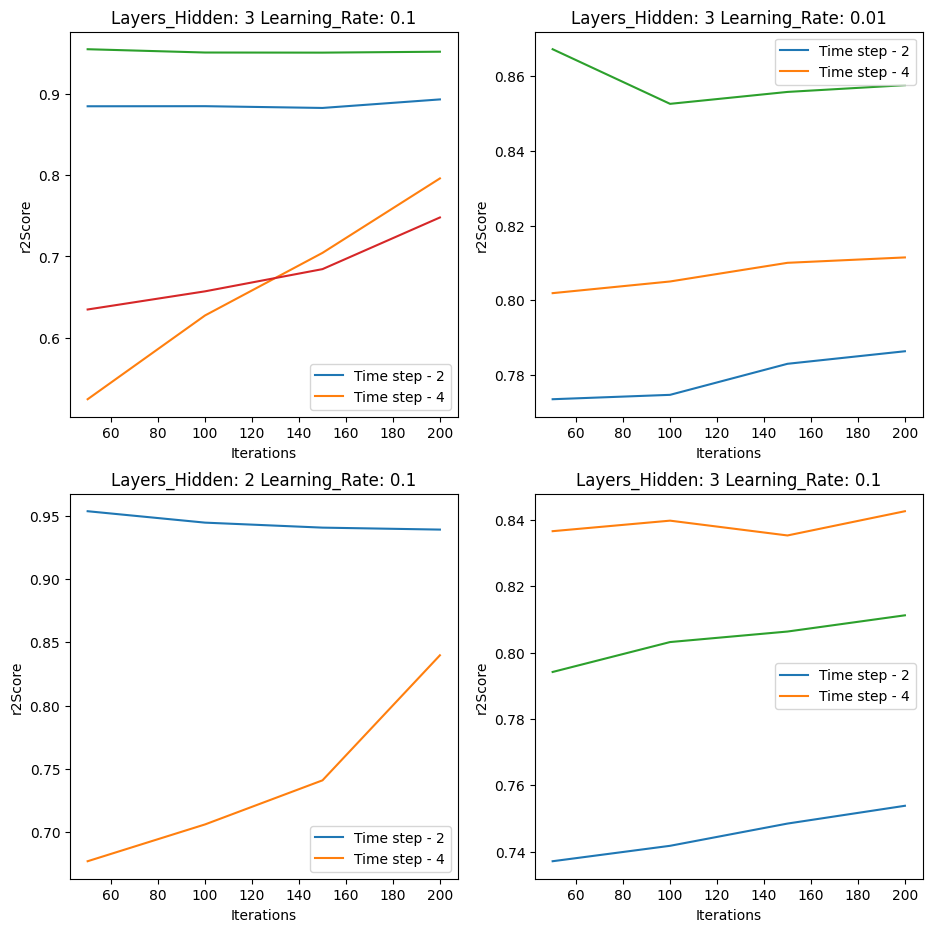

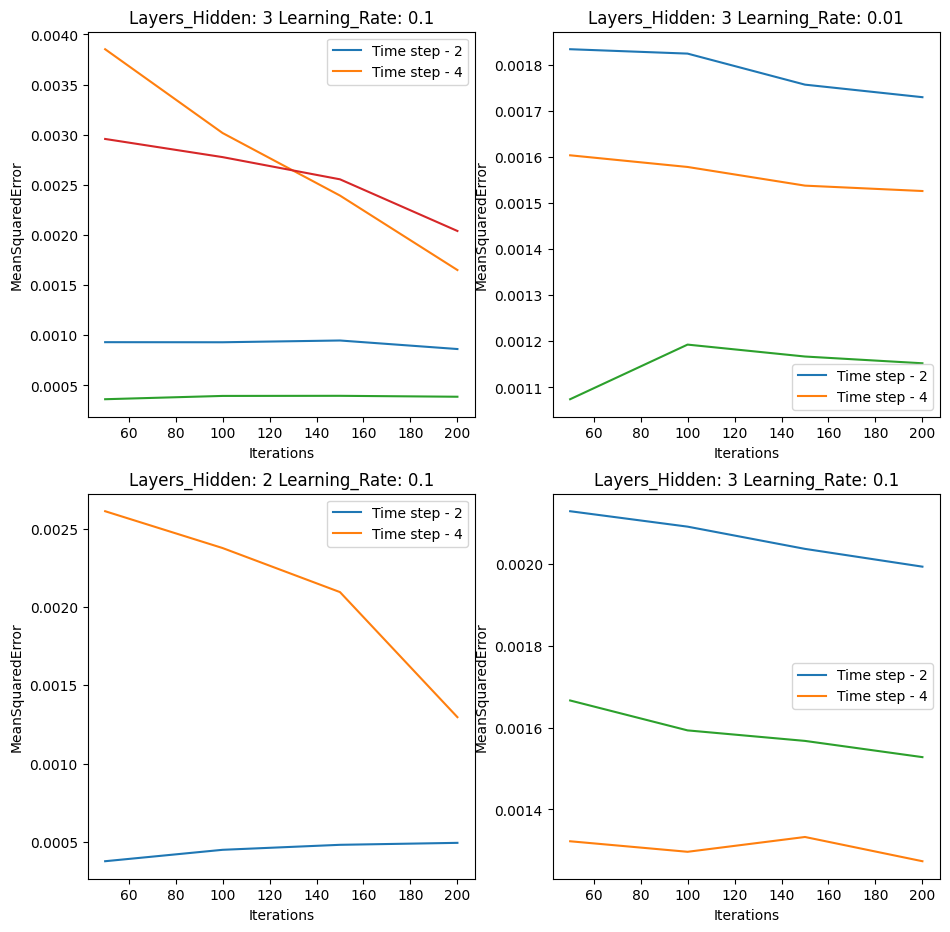

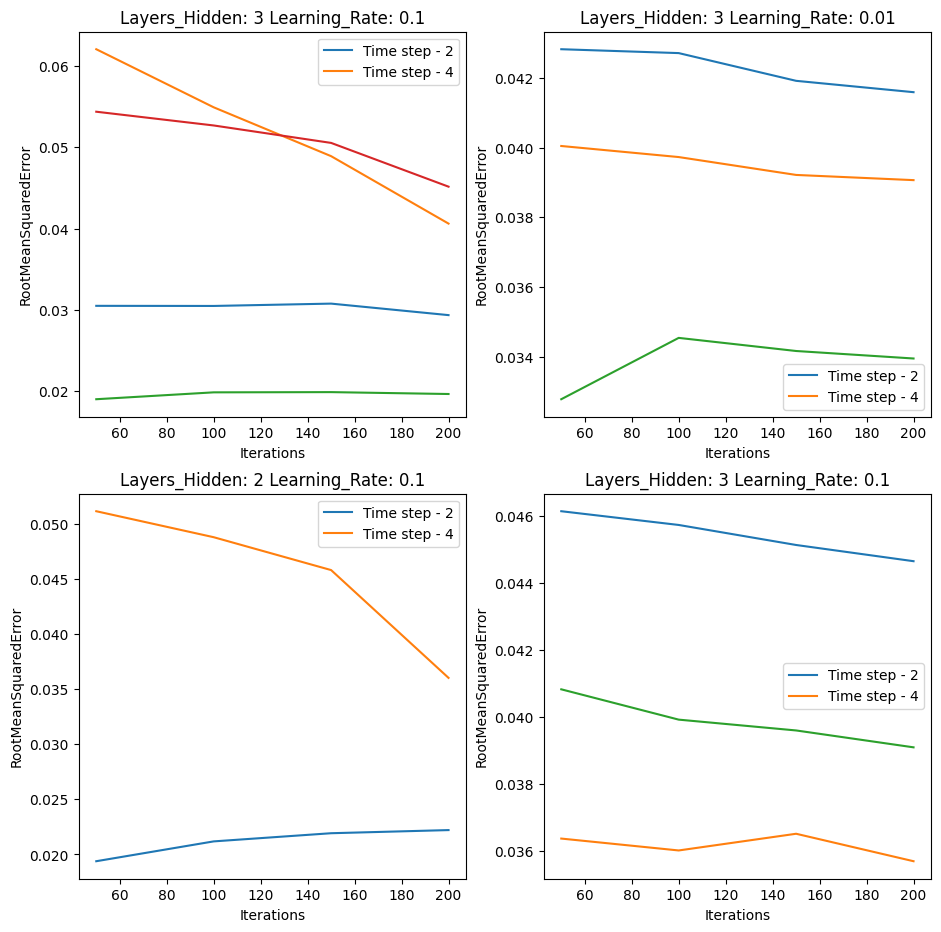

In [ ]:
def loopHiddenLyrs(hiddenLyrs):
    def loopLRates(LRateList):
        def loopStepTime(stepTimeList):
            nonlocal i, j  # Allow modifying i, j from outer loops

            for stepTime in stepTimeList:
                # Ensure i, j stay within 2x2 bounds by using modulo
                i = i % 2
                j = j % 2

                y = Readings.loc[(Readings['hiddenLyrs'] == hiddenLyrs) &
                                 (Readings['LRate'] == LRate) &
                                 (Readings['stepTime'] == stepTime), [mx]]

                ax[i, j].plot(maxItrsList, npy.array(y))
                Title = f'Layers_Hidden: {hiddenLyrs} Learning_Rate: {LRate}'
                ax[i, j].set(xlabel='Iterations', ylabel=mx, title=Title)
                ax[i, j].legend([f'Time step - {stepTime}' for stepTime in stepTimeList])

                # Increment subplot indices
                j += 1  # Move to the next column
                if j >= 2:  # If out of bounds, move to next row and reset column
                    j = 0
                    i += 1

        for j, LRate in enumerate(LRateList):
            loopStepTime(stepTimeList=stepTimeList)

    i, j = 0, 0  # Initialize subplot indices
    for i, hiddenLyrs in enumerate(hiddenLyrsList):
        loopLRates(LRateList=LRateList)  #


for mx in ['r2Score', 'MeanSquaredError', 'RootMeanSquaredError']:
    fig, ax = plot.subplots(2, 2, figsize=(11,11))
    loopHiddenLyrs(hiddenLyrs)
    plot.show()

In [ ]:
#Best Hyper Parameters Choosen after Result Obervations
LRate=0.01
maxItrs=100
stepTime=2
hiddenLyrs=2

model = LongShortTermMemory(LRate, maxItrs, stepTime, frame=(1, 1), hiddenLyrs= hiddenLyrs)
model.modelFitting(xTrain, yTrain)

yPrediction = model.Prediction(xTest)

r2Score = r2_score(yTest, yPrediction)
MeanSquaredError = mean_squared_error(yTest, yPrediction)
RootMeanSquaredError = MeanSquaredError ** 0.5

print('R2 Score:\t',r2Score)
print('Mean Squared Error "MSE":\t',MeanSquaredError)
print('Root Mean Squared Error "RMSE":\t',RootMeanSquaredError)

# Plot Prediction Graph
plot.plot(yTest, label="Actual")
plot.plot(yPrediction, label="Prediction")
plot.legend()
plot.show()